<a href="https://colab.research.google.com/github/mia99maixu/Xye4ggZIOMEpRLWy/blob/main/ValueInvestor2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Goal:
  Our goal is to establish a robust intelligent system to aid our value investing efforts using stock market data. We make investment decisions and based on intrinsic value of companies and do not trade on the basis of daily market volatility. Our profit realization strategy typically involves weekly, monthly and quarterly performance of stocks we buy or hold.

In [ ]:
!pip install torch

import torch

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset


# Define the LSTM Model

In [3]:
# Define the LSTM Model
class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(StockLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Output from the last time step
        return out

# Function to create sequences with variable prediction horizons for LSTM and Pre-process

In [4]:
# Function to create sequences with variable prediction horizons for LSTM
def create_sequences(features, target, window_size, prediction_horizon=1):
    sequences = []
    labels = []
    for i in range(len(features) - window_size - prediction_horizon + 1):
        # Extract a sequence of length `window_size`
        sequence = features[i:i+window_size]
        # Extract a label of length `prediction_horizon` (multiple outputs if horizon > 1)
        label = target[i+window_size:i+window_size+prediction_horizon] if target is not None else None
        sequences.append(sequence)
        if label is not None:
            labels.append(label)

    # Convert sequences and labels to numpy arrays
    if labels:
        return np.array(sequences), np.array(labels)
    return np.array(sequences), None

In [5]:
# Function to preprocess data, train, and predict for price prediction
def process_company(company_data, window_size, prediction_horizon=1):
    features = ['Open', 'High', 'Low', 'Vol.', 'Change %']
    target = 'Price'

    # Normalize features and target
    scaler_features = MinMaxScaler()
    scaler_target = MinMaxScaler()
    scaled_features = scaler_features.fit_transform(company_data[features])
    scaled_target = scaler_target.fit_transform(company_data[[target]])

    # Create sequences for LSTM
    X, y = create_sequences(scaled_features, scaled_target, window_size, prediction_horizon)

    # Split into training and testing (80/20 split)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Convert to PyTorch tensors
    X_train_tensor = torch.Tensor(X_train)
    y_train_tensor = torch.Tensor(y_train)
    X_test_tensor = torch.Tensor(X_test)
    y_test_tensor = torch.Tensor(y_test)

    # DataLoader for batching
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Define the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define LSTM model with output size equal to prediction horizon
    input_size = len(features)
    hidden_size = 64
    num_layers = 2
    output_size = prediction_horizon  # Set output size based on prediction horizon
    model = StockLSTM(input_size, hidden_size, num_layers, output_size).to(device)

    # Define loss function and optimizer
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Set the batch size
    batch_size = 32

    # Train the model
    num_epochs = 10
    test_losses = []
    test_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (X_batch, y_batch) in enumerate(train_loader):  # Use enumerate for iteration number
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_batch = y_batch.reshape(-1, prediction_horizon)
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Evaluate on test data
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor.to(device))
            test_loss = loss_fn(test_outputs, y_test_tensor.reshape(-1, prediction_horizon).to(device))
            test_losses.append(test_loss.item())

            threshold = 0.05
            correct_predictions = torch.abs(test_outputs - y_test_tensor.reshape(-1, prediction_horizon).to(device)) < threshold
            accuracy = torch.sum(correct_predictions).item() / (len(y_test_tensor) * prediction_horizon)
            test_accuracies.append(accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Test Loss: {test_loss.item():.4f}')


    # Prediction on new data
    scaled_features_2021_Q1 = scaler_features.transform(company_data[features])
    X_2021_Q1, _ = create_sequences(scaled_features_2021_Q1, None, window_size)
    X_2021_Q1_tensor = torch.Tensor(X_2021_Q1).to(device)

    model.eval()
    with torch.no_grad():
        predictions_2021_Q1 = model(X_2021_Q1_tensor).cpu().numpy()

    # Inverse scale predictions to original prices
    predicted_prices_2021_Q1 = scaler_target.inverse_transform(predictions_2021_Q1)

    return predicted_prices_2021_Q1


# Original model


In [ ]:
#(Original) Function to preprocess data, train, and predict for price prediction
def process_company(company_data, window_size, prediction_horizon=1):
    features = ['Open', 'High', 'Low', 'Vol.', 'Change %']
    target = 'Price'

    # Normalize features and target
    scaler_features = MinMaxScaler()
    scaler_target = MinMaxScaler()
    scaled_features = scaler_features.fit_transform(company_data[features])
    scaled_target = scaler_target.fit_transform(company_data[[target]])

    # Create sequences for LSTM
    X, y = create_sequences(scaled_features, scaled_target, window_size, prediction_horizon)

    # Split into training and testing (80/20 split)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Convert to PyTorch tensors
    X_train_tensor = torch.Tensor(X_train)
    y_train_tensor = torch.Tensor(y_train)
    X_test_tensor = torch.Tensor(X_test)
    y_test_tensor = torch.Tensor(y_test)

    # DataLoader for batching
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Define the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define LSTM model with output size equal to prediction horizon
    input_size = len(features)
    hidden_size = 64
    num_layers = 2
    output_size = prediction_horizon  # Set output size based on prediction horizon
    model = StockLSTM(input_size, hidden_size, num_layers, output_size).to(device)

    # Define loss function and optimizer
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Set the batch size
    batch_size = 32

    # Train the model
    num_epochs = 10
    for epoch in range(num_epochs):
      for i in range(0, len(X), batch_size):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Zero the gradients
            optimizer.zero_grad()
            # Reshape to (batch_size, prediction_horizon)
            y_batch = y_batch.reshape(-1, prediction_horizon)

            # Forward pass
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)  # Adjust loss for multi-step output

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')

    # Prediction on new data
    scaled_features_2021_Q1 = scaler_features.transform(company_data[features])
    X_2021_Q1, _ = create_sequences(scaled_features_2021_Q1, None, window_size)
    X_2021_Q1_tensor = torch.Tensor(X_2021_Q1).to(device)

    model.eval()
    with torch.no_grad():
        predictions_2021_Q1 = model(X_2021_Q1_tensor).cpu().numpy()

    # Inverse scale predictions to original prices
    predicted_prices_2021_Q1 = scaler_target.inverse_transform(predictions_2021_Q1)

    return predicted_prices_2021_Q1


# Mount to the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load the Data

In [6]:
# Load the provided Excel file with multiple sheets to examine its structure and content
file_path = '/content/drive/My Drive/Apziva/2020Q1Q2Q3Q4-2021Q1.xlsx'
sheets_dict = pd.read_excel(file_path, sheet_name=None)  # Load all sheets into a dictionary

# Display information for each sheet to understand the structure of each company's data
sheet_info = {sheet_name: df.info() for sheet_name, df in sheets_dict.items()}
first_rows = {sheet_name: df.head() for sheet_name, df in sheets_dict.items()}

sheet_info, first_rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      312 non-null    object 
 1   Price     312 non-null    object 
 2   Open      312 non-null    object 
 3   High      312 non-null    object 
 4   Low       312 non-null    object 
 5   Vol.      311 non-null    object 
 6   Change %  311 non-null    float64
dtypes: float64(1), object(6)
memory usage: 17.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316 entries, 0 to 315
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      316 non-null    object 
 1   Price     316 non-null    object 
 2   Open      316 non-null    object 
 3   High      316 non-null    object 
 4   Low       316 non-null    object 
 5   Vol.      315 non-null    object 
 6   Change %  315 non-null    float64
dtypes: float64(1), object(6)
memory 

({'Russia - Sberbank Rossii PAO (S': None,
  'Turkey - Koc Holding AS (KCHOL)': None,
  'Egypt - Medinet Nasr Housing (M': None,
  'Brazil - Minerva SABrazil (BEEF': None,
  'Argentina - Pampa Energia SA (P': None,
  'Colombia - Cementos Argos SA (C': None,
  'South Africa - Impala Platinum ': None,
  'South Korea - Dongkuk Steel Mil': None},
 {'Russia - Sberbank Rossii PAO (S':                   Date   Price    Open    High     Low    Vol.  Change %
  0  2021-03-31 00:00:00  291.02     294  294.42  290.26  47.00M   -0.0076
  1  2021-03-30 00:00:00  293.25  294.86  295.72   291.5  38.81M   -0.0002
  2  2021-03-29 00:00:00   293.3  289.72  294.09  289.26  43.68M    0.0071
  3  2021-03-26 00:00:00  291.22  288.63  292.75  288.32  56.07M    0.0159
  4  2021-03-25 00:00:00  286.66   286.5  287.03  283.85  35.22M    0.0030,
  'Turkey - Koc Holding AS (KCHOL)':                   Date  Price   Open   High    Low    Vol.  Change %
  0  2021-03-31 00:00:00  19.41  19.42  19.63  19.27  13.14M   

In [7]:
def init_preprocess(df):
    # Removing the last row from df
    df = df.iloc[:-1].copy()

    # Converting 'Vol.' column to numeric by handling 'M', 'K', and '-' symbols
    df['Vol.'] = df['Vol.'].str.replace('M', 'e6').str.replace('K', 'e3').str.replace('-', '0').astype(float)

    # Remove '%' from 'Change %' and convert to numeric if present
    if 'Change %' in df.columns:
        # Ensure 'Change %' column is of string type
        df['Change %'] = df['Change %'].astype(str)
        # Remove '%' only if present, otherwise, keep as is
        df['Change %'] = df['Change %'].apply(lambda x: x.replace('%', '') if '%' in x else x)
        df['Change %'] = pd.to_numeric(df['Change %'], errors='coerce') # Convert to numeric

    # Convert remaining columns to float
    numeric_cols = df.columns.drop(['Vol.', 'Change %', 'Date'], errors='ignore')
    df[numeric_cols] = df[numeric_cols].astype(float)


    # Convert Date column to datetime if not already the index
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.set_index('Date')

    # Sort by the datetime index
    df = df.sort_index()

    # Display information about the cleaned dataframe
    df.info()
    print(df.tail())

    return df

In [8]:
# Apply the ini_preprocess function to each sheet and store results in a new dictionary
cleaned_sheets_dict = {sheet_name: init_preprocess(df.copy()) for sheet_name, df in sheets_dict.items()}

# Display information for each cleaned sheet
for sheet_name, cleaned_df in cleaned_sheets_dict.items():
    print(f"Data for {sheet_name} after cleaning:")
    print(cleaned_df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 311 entries, 2020-01-03 to 2021-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     311 non-null    float64
 1   Open      311 non-null    float64
 2   High      311 non-null    float64
 3   Low       311 non-null    float64
 4   Vol.      311 non-null    float64
 5   Change %  311 non-null    float64
dtypes: float64(6)
memory usage: 17.0 KB
             Price    Open    High     Low        Vol.  Change %
Date                                                            
2021-03-25  286.66  286.50  287.03  283.85  35220000.0    0.0030
2021-03-26  291.22  288.63  292.75  288.32  56070000.0    0.0159
2021-03-29  293.30  289.72  294.09  289.26  43680000.0    0.0071
2021-03-30  293.25  294.86  295.72  291.50  38810000.0   -0.0002
2021-03-31  291.02  294.00  294.42  290.26  47000000.0   -0.0076
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315 entries, 202

In [9]:
company_names = []
for sheet_name in sheets_dict:
    company_names.append(sheet_name)
company_names

['Russia - Sberbank Rossii PAO (S',
 'Turkey - Koc Holding AS (KCHOL)',
 'Egypt - Medinet Nasr Housing (M',
 'Brazil - Minerva SABrazil (BEEF',
 'Argentina - Pampa Energia SA (P',
 'Colombia - Cementos Argos SA (C',
 'South Africa - Impala Platinum ',
 'South Korea - Dongkuk Steel Mil']

# Display predictions for the specific company
### Russia - Sberbank Rossii PAO

In [15]:
# Set parameters
window_size = 10
prediction_horizons = [1, 5, 20]  # Daily, weekly (5-day), monthly (20-day)

# Store predictions
predictions_dict = {}

# Define which company to predict
company_name = 'Russia - Sberbank Rossii PAO (S'
df = sheets_dict[company_name]  # Load the data for the specific company
cleaned_df = init_preprocess(df)  # Preprocess the data

# Store predictions for the specified company
predictions_dict = {company_name: {}}

# Run predictions for each horizon (daily, weekly, monthly) for the specified company
for horizon in prediction_horizons:
    predictions = process_company(cleaned_df, window_size, prediction_horizon=horizon)
    predictions_dict[company_name][f'{horizon}-day'] = predictions
    print(f"{horizon}-day Predictions for {company_name}: {predictions}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 311 entries, 2020-01-03 to 2021-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     311 non-null    float64
 1   Open      311 non-null    float64
 2   High      311 non-null    float64
 3   Low       311 non-null    float64
 4   Vol.      311 non-null    float64
 5   Change %  311 non-null    float64
dtypes: float64(6)
memory usage: 17.0 KB
             Price    Open    High     Low        Vol.  Change %
Date                                                            
2021-03-25  286.66  286.50  287.03  283.85  35220000.0    0.0030
2021-03-26  291.22  288.63  292.75  288.32  56070000.0    0.0159
2021-03-29  293.30  289.72  294.09  289.26  43680000.0    0.0071
2021-03-30  293.25  294.86  295.72  291.50  38810000.0   -0.0002
2021-03-31  291.02  294.00  294.42  290.26  47000000.0   -0.0076
Epoch 1/10, Loss: 0.2342, Test Loss: 0.6388
Epoch 2/10, Loss: 0.1377,

# Display predictions for the specific company
### Turkey - Koc Holding AS (KCHOL)

In [ ]:
# Set parameters
window_size = 10
prediction_horizons = [1, 5, 20]  # Daily, weekly (5-day), monthly (20-day)

# Store predictions
predictions_dict = {}

# Define which company to predict
company_name = 'Turkey - Koc Holding AS (KCHOL)'
df = sheets_dict[company_name]  # Load the data for the specific company
cleaned_df = init_preprocess(df)  # Preprocess the data

# Store predictions for the specified company
predictions_dict = {company_name: {}}

# Run predictions for each horizon (daily, weekly, monthly) for the specified company
for horizon in prediction_horizons:
    predictions = process_company(cleaned_df, window_size, prediction_horizon=horizon)
    predictions_dict[company_name][f'{horizon}-day'] = predictions
    print(f"{horizon}-day Predictions for {company_name}: {predictions}")



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315 entries, 2020-01-02 to 2021-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     315 non-null    float64
 1   Open      315 non-null    float64
 2   High      315 non-null    float64
 3   Low       315 non-null    float64
 4   Vol.      315 non-null    float64
 5   Change %  315 non-null    float64
dtypes: float64(6)
memory usage: 17.2 KB
            Price   Open   High    Low        Vol.  Change %
Date                                                        
2021-03-25  20.02  20.50  20.86  20.02  15930000.0   -0.0148
2021-03-26  19.25  20.28  20.36  19.10  21350000.0   -0.0385
2021-03-29  19.10  19.24  19.67  19.10  16560000.0   -0.0078
2021-03-30  19.50  19.12  19.81  19.03  21050000.0    0.0209
2021-03-31  19.41  19.42  19.63  19.27  13140000.0   -0.0046
Epoch 1/10, Loss: 0.1708, Test Loss: 0.5720
Epoch 2/10, Loss: 0.1080, Test Loss: 0.3974
Epoch 3/1

# Display predictions for the specific company
### Egypt - Medinet Nasr Housing

In [ ]:
# Set parameters
window_size = 10
prediction_horizons = [1, 5, 20]  # Daily, weekly (5-day), monthly (20-day)

# Store predictions
predictions_dict = {}

# Define which company to predict
company_name = 'Egypt - Medinet Nasr Housing (M'
df = sheets_dict[company_name]  # Load the data for the specific company
cleaned_df = init_preprocess(df)  # Preprocess the data

# Store predictions for the specified company
predictions_dict = {company_name: {}}

# Run predictions for each horizon (daily, weekly, monthly) for the specified company
for horizon in prediction_horizons:
    predictions = process_company(cleaned_df, window_size, prediction_horizon=horizon)
    predictions_dict[company_name][f'{horizon}-day'] = predictions
    print(f"{horizon}-day Predictions for {company_name}: {predictions}")



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 305 entries, 2020-01-02 to 2021-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     305 non-null    float64
 1   Open      305 non-null    float64
 2   High      305 non-null    float64
 3   Low       305 non-null    float64
 4   Vol.      305 non-null    float64
 5   Change %  305 non-null    float64
dtypes: float64(6)
memory usage: 16.7 KB
            Price  Open  High   Low       Vol.  Change %
Date                                                    
2021-03-25   3.71  3.62  3.78  3.59  2500000.0    0.0137
2021-03-28   3.71  3.76  3.76  3.68  2340000.0    0.0000
2021-03-29   3.70  3.69  3.73  3.68  1250000.0   -0.0027
2021-03-30   3.73  3.71  3.76  3.67  3430000.0    0.0081
2021-03-31   3.75  3.74  3.82  3.71  1570000.0    0.0054
Epoch 1/10, Loss: 0.3153, Test Loss: 0.3546
Epoch 2/10, Loss: 0.2106, Test Loss: 0.2147
Epoch 3/10, Loss: 0.1167, Test Loss: 

# Display predictions for the specific company
### Brazil - Minerva SABrazil

In [ ]:
# Set parameters
window_size = 10
prediction_horizons = [1, 5, 20]  # Daily, weekly (5-day), monthly (20-day)

# Store predictions
predictions_dict = {}

# Define which company to predict
company_name = 'Brazil - Minerva SABrazil (BEEF'
df = sheets_dict[company_name]  # Load the data for the specific company
cleaned_df = init_preprocess(df)  # Preprocess the data

# Store predictions for the specified company
predictions_dict = {company_name: {}}

# Run predictions for each horizon (daily, weekly, monthly) for the specified company
for horizon in prediction_horizons:
    predictions = process_company(cleaned_df, window_size, prediction_horizon=horizon)
    predictions_dict[company_name][f'{horizon}-day'] = predictions
    print(f"{horizon}-day Predictions for {company_name}: {predictions}")



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 309 entries, 2020-01-02 to 2021-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     309 non-null    float64
 1   Open      309 non-null    float64
 2   High      309 non-null    float64
 3   Low       309 non-null    float64
 4   Vol.      309 non-null    float64
 5   Change %  309 non-null    float64
dtypes: float64(6)
memory usage: 16.9 KB
            Price   Open   High    Low        Vol.  Change %
Date                                                        
2021-03-25   9.80  10.01  10.01   9.66   8880000.0   -0.0151
2021-03-26   9.83   9.80   9.94   9.70   5110000.0    0.0031
2021-03-29  10.47   9.85  10.50   9.81  22040000.0    0.0651
2021-03-30  10.36  10.41  10.62  10.30   9930000.0   -0.0105
2021-03-31  10.20  10.35  10.40  10.12   7770000.0   -0.0154
Epoch 1/10, Loss: 0.3769, Test Loss: 0.0792
Epoch 2/10, Loss: 0.2639, Test Loss: 0.0283
Epoch 3/1

# Display predictions for the specific company
### Argentina - Pampa Energia SA

In [ ]:
# Set parameters
window_size = 10
prediction_horizons = [1, 5, 20]  # Daily, weekly (5-day), monthly (20-day)

# Store predictions
predictions_dict = {}

# Define which company to predict
company_name = 'Argentina - Pampa Energia SA (P'
df = sheets_dict[company_name]  # Load the data for the specific company
cleaned_df = init_preprocess(df)  # Preprocess the data

# Store predictions for the specified company
predictions_dict = {company_name: {}}

# Run predictions for each horizon (daily, weekly, monthly) for the specified company
for horizon in prediction_horizons:
    predictions = process_company(cleaned_df, window_size, prediction_horizon=horizon)
    predictions_dict[company_name][f'{horizon}-day'] = predictions
    print(f"{horizon}-day Predictions for {company_name}: {predictions}")



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 300 entries, 2020-01-02 to 2021-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     300 non-null    float64
 1   Open      300 non-null    float64
 2   High      300 non-null    float64
 3   Low       300 non-null    float64
 4   Vol.      300 non-null    float64
 5   Change %  300 non-null    float64
dtypes: float64(6)
memory usage: 16.4 KB
            Price   Open   High    Low      Vol.  Change %
Date                                                      
2021-03-25  83.60  85.20  87.30  82.10  389780.0   -0.0313
2021-03-26  81.85  84.00  84.60  80.70  462550.0   -0.0209
2021-03-29  85.00  80.00  86.00  79.00  371220.0    0.0385
2021-03-30  86.10  85.15  86.75  84.60  141400.0    0.0129
2021-03-31  85.15  86.50  88.10  85.15  564300.0   -0.0110
Epoch 1/10, Loss: 0.2480, Test Loss: 0.6601
Epoch 2/10, Loss: 0.1657, Test Loss: 0.4510
Epoch 3/10, Loss: 0.085

# Display predictions for the specific company
### Colombia - Cementos Argos SA

In [ ]:
# Set parameters
window_size = 10
prediction_horizons = [1, 5, 20]  # Daily, weekly (5-day), monthly (20-day)

# Store predictions
predictions_dict = {}

# Define which company to predict
company_name = 'Colombia - Cementos Argos SA (C'
df = sheets_dict[company_name]  # Load the data for the specific company
cleaned_df = init_preprocess(df)  # Preprocess the data

# Store predictions for the specified company
predictions_dict = {company_name: {}}

# Run predictions for each horizon (daily, weekly, monthly) for the specified company
for horizon in prediction_horizons:
    predictions = process_company(cleaned_df, window_size, prediction_horizon=horizon)
    predictions_dict[company_name][f'{horizon}-day'] = predictions
    print(f"{horizon}-day Predictions for {company_name}: {predictions}")



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 303 entries, 2020-01-02 to 2021-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     303 non-null    float64
 1   Open      303 non-null    float64
 2   High      303 non-null    float64
 3   Low       303 non-null    float64
 4   Vol.      303 non-null    float64
 5   Change %  303 non-null    float64
dtypes: float64(6)
memory usage: 16.6 KB
             Price    Open    High     Low      Vol.  Change %
Date                                                          
2021-03-25  5030.0  5035.0  5045.0  4950.0  317060.0    0.0010
2021-03-26  5020.0  5085.0  5085.0  4980.0  203460.0   -0.0020
2021-03-29  5045.0  5020.0  5045.0  5015.0  117540.0    0.0050
2021-03-30  5100.0  5010.0  5100.0  5010.0  583700.0    0.0109
2021-03-31  5150.0  5100.0  5170.0  5100.0  212440.0    0.0098
Epoch 1/10, Loss: 0.2692, Test Loss: 0.3814
Epoch 2/10, Loss: 0.1489, Test Loss: 0.

# Display predictions for the specific company
### South Africa - Impala Platinum

In [ ]:
# Set parameters
window_size = 10
prediction_horizons = [1, 5, 20]  # Daily, weekly (5-day), monthly (20-day)

# Store predictions
predictions_dict = {}

# Define which company to predict
company_name = 'South Africa - Impala Platinum '
df = sheets_dict[company_name]  # Load the data for the specific company
cleaned_df = init_preprocess(df)  # Preprocess the data

# Store predictions for the specified company
predictions_dict = {company_name: {}}

# Run predictions for each horizon (daily, weekly, monthly) for the specified company
for horizon in prediction_horizons:
    predictions = process_company(cleaned_df, window_size, prediction_horizon=horizon)
    predictions_dict[company_name][f'{horizon}-day'] = predictions
    print(f"{horizon}-day Predictions for {company_name}: {predictions}")



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 314 entries, 2020-01-02 to 2021-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     314 non-null    float64
 1   Open      314 non-null    float64
 2   High      314 non-null    float64
 3   Low       314 non-null    float64
 4   Vol.      314 non-null    float64
 5   Change %  314 non-null    float64
dtypes: float64(6)
memory usage: 17.2 KB
              Price     Open     High      Low       Vol.  Change %
Date                                                               
2021-03-25  26564.0  25954.0  27128.0  25954.0  2830000.0    0.0255
2021-03-26  27533.0  27083.0  28006.0  26728.0  3360000.0    0.0365
2021-03-29  26980.0  27800.0  28174.0  26614.0  4440000.0   -0.0201
2021-03-30  26898.0  26766.0  27443.0  26360.0  3020000.0   -0.0030
2021-03-31  27373.0  26980.0  27526.0  26657.0  2490000.0    0.0177
Epoch 1/10, Loss: 0.0962, Test Loss: 0.3986
Epoc

# Display predictions for the specific company
### South Korea - Dongkuk Steel Mil

In [ ]:
# Set parameters
window_size = 10
prediction_horizons = [1, 5, 20]  # Daily, weekly (5-day), monthly (20-day)

# Store predictions
predictions_dict = {}

# Define which company to predict
company_name = 'South Korea - Dongkuk Steel Mil'
df = sheets_dict[company_name]  # Load the data for the specific company
cleaned_df = init_preprocess(df)  # Preprocess the data

# Store predictions for the specified company
predictions_dict = {company_name: {}}

# Run predictions for each horizon (daily, weekly, monthly) for the specified company
for horizon in prediction_horizons:
    predictions = process_company(cleaned_df, window_size, prediction_horizon=horizon)
    predictions_dict[company_name][f'{horizon}-day'] = predictions
    print(f"{horizon}-day Predictions for {company_name}: {predictions}")



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 341 entries, 2020-01-02 to 2021-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     341 non-null    float64
 1   Open      341 non-null    float64
 2   High      341 non-null    float64
 3   Low       341 non-null    float64
 4   Vol.      341 non-null    float64
 5   Change %  341 non-null    float64
dtypes: float64(6)
memory usage: 18.6 KB
              Price     Open     High      Low       Vol.  Change %
Date                                                               
2021-03-26  12200.0  11500.0  12300.0  11350.0  2340000.0    0.0796
2021-03-28  12200.0  12200.0  12200.0  12200.0        0.0    0.0000
2021-03-29  13550.0  12500.0  13800.0  12500.0      200.0    0.1107
2021-03-30  13650.0  13850.0  14200.0  13050.0  3170000.0    0.0074
2021-03-31  13650.0  13700.0  13750.0  13450.0      190.0    0.0000
Epoch 1/10, Loss: 0.0879, Test Loss: 0.2862
Epoc

# Trading Capital returns

In [ ]:
# Function for trading algorithm to evaluate the capital return in Bollinger Bands, the function should also include plotting for the Bollinger Bands, and the price should be the prediction from the train model, and show example

import matplotlib.pyplot as plt

def trading_algorithm(df, predictions, window=20):
    """
    Evaluates capital return using Bollinger Bands and plots the results.

    Args:
        df: DataFrame with 'Price' column representing actual prices.
        predictions: Predicted prices.
        window: Window size for Bollinger Bands calculation.
    """

    # Calculate Bollinger Bands
    df['SMA'] = df['Price'].rolling(window=window).mean()
    df['StdDev'] = df['Price'].rolling(window=window).std()
    df['Upper'] = df['SMA'] + (df['StdDev'] * 2)
    df['Lower'] = df['SMA'] - (df['StdDev'] * 2)

    # Plotting
    plt.figure(figsize=(14, 7))
    plt.plot(df['Price'], label='Actual Price', alpha=0.7)
    plt.plot(predictions, label='Predicted Price', alpha=0.7)
    plt.plot(df['SMA'], label='SMA', linestyle='--', alpha=0.7)
    plt.plot(df['Upper'], label='Upper Band', linestyle='--', alpha=0.7)
    plt.plot(df['Lower'], label='Lower Band', linestyle='--', alpha=0.7)
    plt.fill_between(df.index, df['Upper'], df['Lower'], color='lightgray', alpha=0.3)
    plt.title('Bollinger Bands with Predicted Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()


    # Trading Logic
    capital = 1000
    shares = 0
    transactions = []

    for i in range(window, len(df)):
      if predictions[i] > df['Upper'][i] and capital > 0: # Buy signal
          shares_to_buy = int(capital / predictions[i])
          shares += shares_to_buy
          capital -= shares_to_buy * predictions[i]
          transactions.append(('Buy', df.index[i], predictions[i], shares_to_buy))
      elif predictions[i] < df['Lower'][i] and shares > 0: # Sell signal
          capital += shares * predictions[i]
          transactions.append(('Sell', df.index[i], predictions[i], shares))
          shares = 0
    # Final evaluation
    final_capital = capital + shares * df['Price'][-1] if shares > 0 else capital
    print("Final capital:", final_capital)
    return final_capital

# Bollinger Band for Daily Prediction Russia

<ipython-input-14-5da0fe9e1c87>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA'] = df['Price'].rolling(window=window).mean()
<ipython-input-14-5da0fe9e1c87>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['StdDev'] = df['Price'].rolling(window=window).std()
<ipython-input-14-5da0fe9e1c87>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

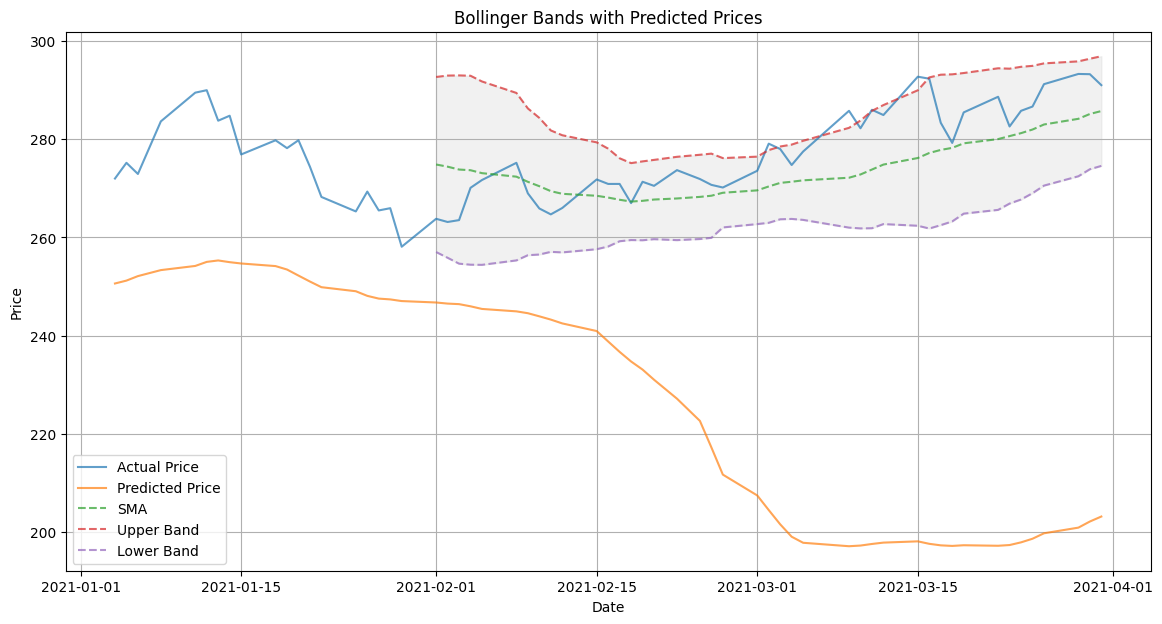

Final capital: 1000


<ipython-input-14-5da0fe9e1c87>:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if predictions[i] > df['Upper'][i] and capital > 0: # Buy signal
<ipython-input-14-5da0fe9e1c87>:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif predictions[i] < df['Lower'][i] and shares > 0: # Sell signal


In [ ]:
# Compare actual data and prediction for RUSSIA
company_name = 'Russia - Sberbank Rossii PAO (S'
# Extract actual prices for Jan, Feb, Mar 2021
actual_prices_2021 = cleaned_df['2021-01-01':'2021-03-31']

# Extract predicted prices (adjust to your horizon)
predicted_prices_2021 = predictions_dict[company_name]['1-day'][:len(actual_prices_2021)]

# Ensure both dataframes have the same index
# The problem lies here, predicted_prices_2021 is 2D, flatten to 1D
predicted_prices_2021 = pd.Series(predicted_prices_2021.flatten(), index=actual_prices_2021.index)


final_capital = trading_algorithm(actual_prices_2021, predicted_prices_2021)

# Bollinger Band for Daily Prediction Turkey

<ipython-input-14-5da0fe9e1c87>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA'] = df['Price'].rolling(window=window).mean()
<ipython-input-14-5da0fe9e1c87>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['StdDev'] = df['Price'].rolling(window=window).std()
<ipython-input-14-5da0fe9e1c87>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

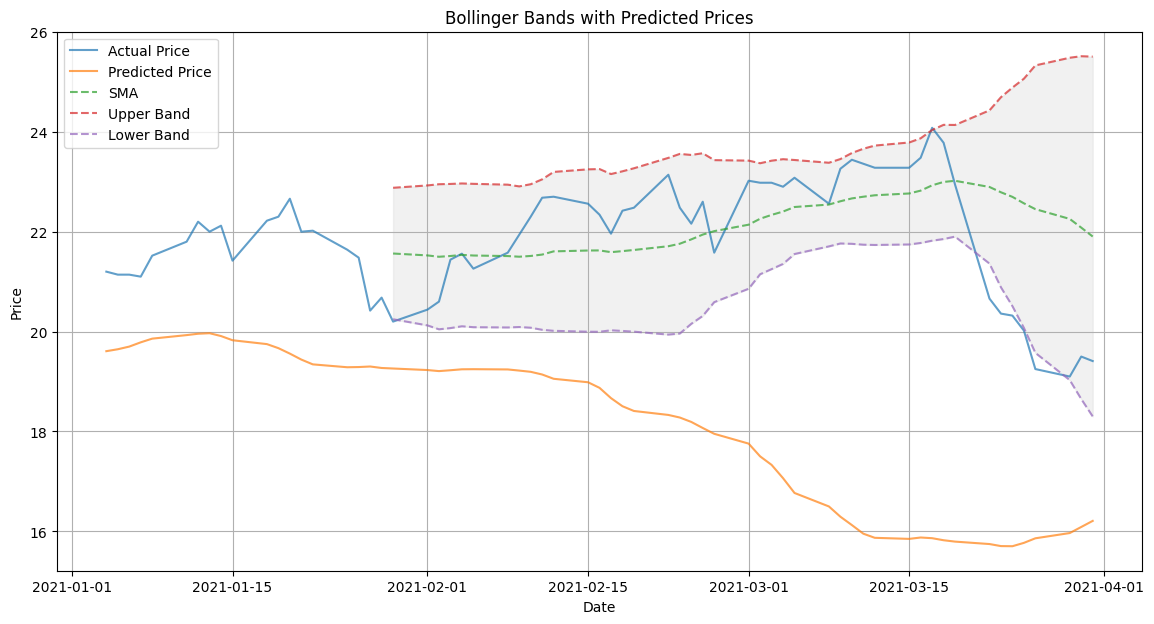

Final capital: 1000


<ipython-input-14-5da0fe9e1c87>:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if predictions[i] > df['Upper'][i] and capital > 0: # Buy signal
<ipython-input-14-5da0fe9e1c87>:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif predictions[i] < df['Lower'][i] and shares > 0: # Sell signal


In [ ]:
# Compare actual data and prediction
company_name = 'Turkey - Koc Holding AS (KCHOL)'
# Extract actual prices for Jan, Feb, Mar 2021
actual_prices_2021 = cleaned_df['2021-01-01':'2021-03-31']

# Extract predicted prices (adjust to your horizon)
predicted_prices_2021 = predictions_dict[company_name]['1-day'][:len(actual_prices_2021)]

# Ensure both dataframes have the same index
# The problem lies here, predicted_prices_2021 is 2D, flatten to 1D
predicted_prices_2021 = pd.Series(predicted_prices_2021.flatten(), index=actual_prices_2021.index)


final_capital = trading_algorithm(actual_prices_2021, predicted_prices_2021)

# Bollinger Band for Daily Prediction Egypt


<ipython-input-14-5da0fe9e1c87>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA'] = df['Price'].rolling(window=window).mean()
<ipython-input-14-5da0fe9e1c87>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['StdDev'] = df['Price'].rolling(window=window).std()
<ipython-input-14-5da0fe9e1c87>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

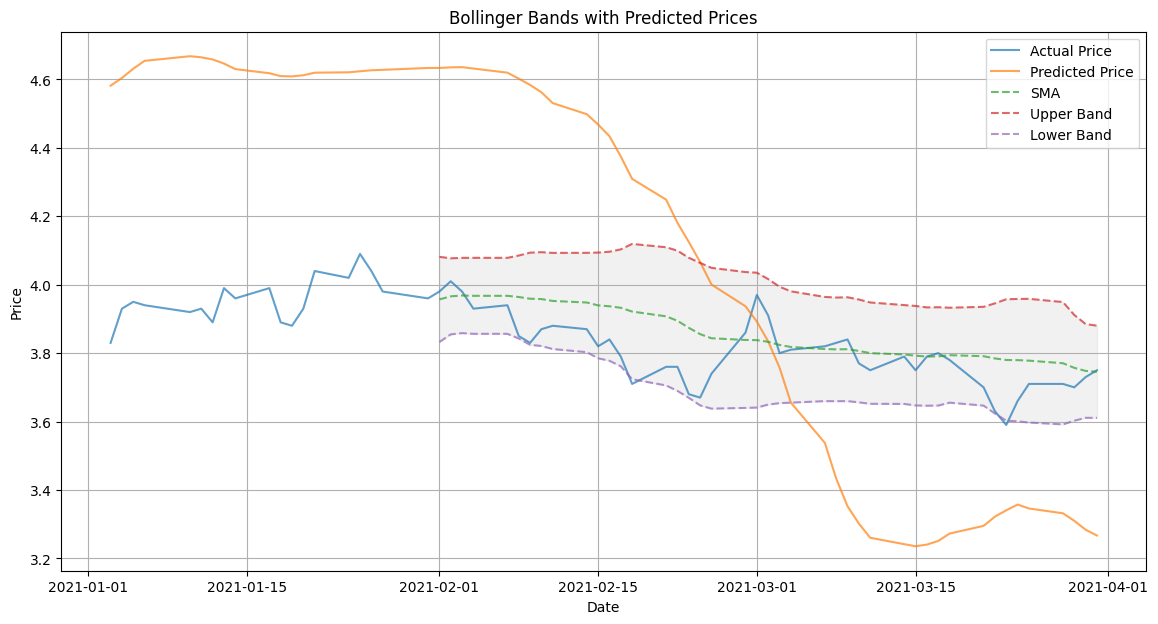

Final capital: 764.0235900878906


<ipython-input-14-5da0fe9e1c87>:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if predictions[i] > df['Upper'][i] and capital > 0: # Buy signal
<ipython-input-14-5da0fe9e1c87>:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  shares_to_buy = int(capital / predictions[i])
<ipython-input-14-5da0fe9e1c87>:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  capital -= shares_to_buy * predictions[i]
<ipython-input-14-5da0fe9e1c87>:47: F

In [ ]:
# Compare actual data and prediction
company_name = 'Egypt - Medinet Nasr Housing (M'
# Extract actual prices for Jan, Feb, Mar 2021
actual_prices_2021 = cleaned_df['2021-01-01':'2021-03-31']

# Extract predicted prices (adjust to your horizon)
predicted_prices_2021 = predictions_dict[company_name]['1-day'][:len(actual_prices_2021)]

# Ensure both dataframes have the same index
# The problem lies here, predicted_prices_2021 is 2D, flatten to 1D
predicted_prices_2021 = pd.Series(predicted_prices_2021.flatten(), index=actual_prices_2021.index)


final_capital = trading_algorithm(actual_prices_2021, predicted_prices_2021)

# Bollinger Band for Daily Prediction Brazil

<ipython-input-14-5da0fe9e1c87>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA'] = df['Price'].rolling(window=window).mean()
<ipython-input-14-5da0fe9e1c87>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['StdDev'] = df['Price'].rolling(window=window).std()
<ipython-input-14-5da0fe9e1c87>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

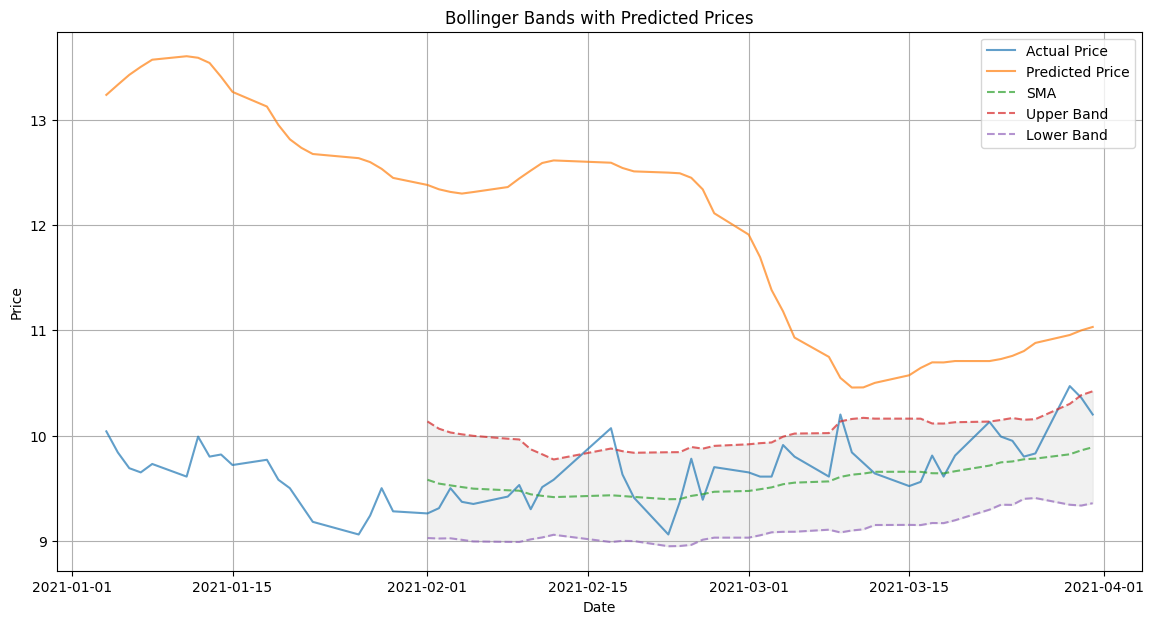

Final capital: 826.6378948211669


<ipython-input-14-5da0fe9e1c87>:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if predictions[i] > df['Upper'][i] and capital > 0: # Buy signal
<ipython-input-14-5da0fe9e1c87>:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  shares_to_buy = int(capital / predictions[i])
<ipython-input-14-5da0fe9e1c87>:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  capital -= shares_to_buy * predictions[i]
<ipython-input-14-5da0fe9e1c87>:47: F

In [ ]:
# Compare actual data and prediction
company_name = 'Brazil - Minerva SABrazil (BEEF'
# Extract actual prices for Jan, Feb, Mar 2021
actual_prices_2021 = cleaned_df['2021-01-01':'2021-03-31']

# Extract predicted prices (adjust to your horizon)
predicted_prices_2021 = predictions_dict[company_name]['1-day'][:len(actual_prices_2021)]

# Ensure both dataframes have the same index
# The problem lies here, predicted_prices_2021 is 2D, flatten to 1D
predicted_prices_2021 = pd.Series(predicted_prices_2021.flatten(), index=actual_prices_2021.index)


final_capital = trading_algorithm(actual_prices_2021, predicted_prices_2021)

# Bollinger Band for Daily Prediction Argentina

<ipython-input-14-5da0fe9e1c87>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA'] = df['Price'].rolling(window=window).mean()
<ipython-input-14-5da0fe9e1c87>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['StdDev'] = df['Price'].rolling(window=window).std()
<ipython-input-14-5da0fe9e1c87>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

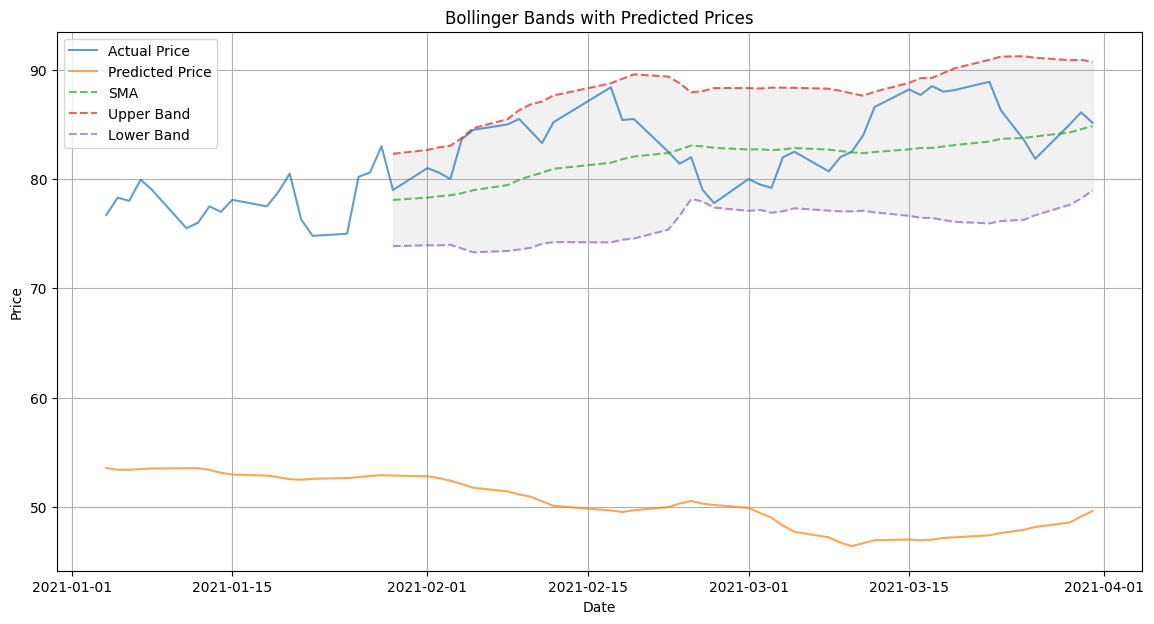

Final capital: 1000


<ipython-input-14-5da0fe9e1c87>:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if predictions[i] > df['Upper'][i] and capital > 0: # Buy signal
<ipython-input-14-5da0fe9e1c87>:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif predictions[i] < df['Lower'][i] and shares > 0: # Sell signal


In [ ]:
# Compare actual data and prediction
company_name = 'Argentina - Pampa Energia SA (P'
# Extract actual prices for Jan, Feb, Mar 2021
actual_prices_2021 = cleaned_df['2021-01-01':'2021-03-31']

# Extract predicted prices (adjust to your horizon)
predicted_prices_2021 = predictions_dict[company_name]['1-day'][:len(actual_prices_2021)]

# Ensure both dataframes have the same index
# The problem lies here, predicted_prices_2021 is 2D, flatten to 1D
predicted_prices_2021 = pd.Series(predicted_prices_2021.flatten(), index=actual_prices_2021.index)


final_capital = trading_algorithm(actual_prices_2021, predicted_prices_2021)

# Bollinger Band for Daily Prediction Colombia

<ipython-input-14-5da0fe9e1c87>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA'] = df['Price'].rolling(window=window).mean()
<ipython-input-14-5da0fe9e1c87>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['StdDev'] = df['Price'].rolling(window=window).std()
<ipython-input-14-5da0fe9e1c87>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

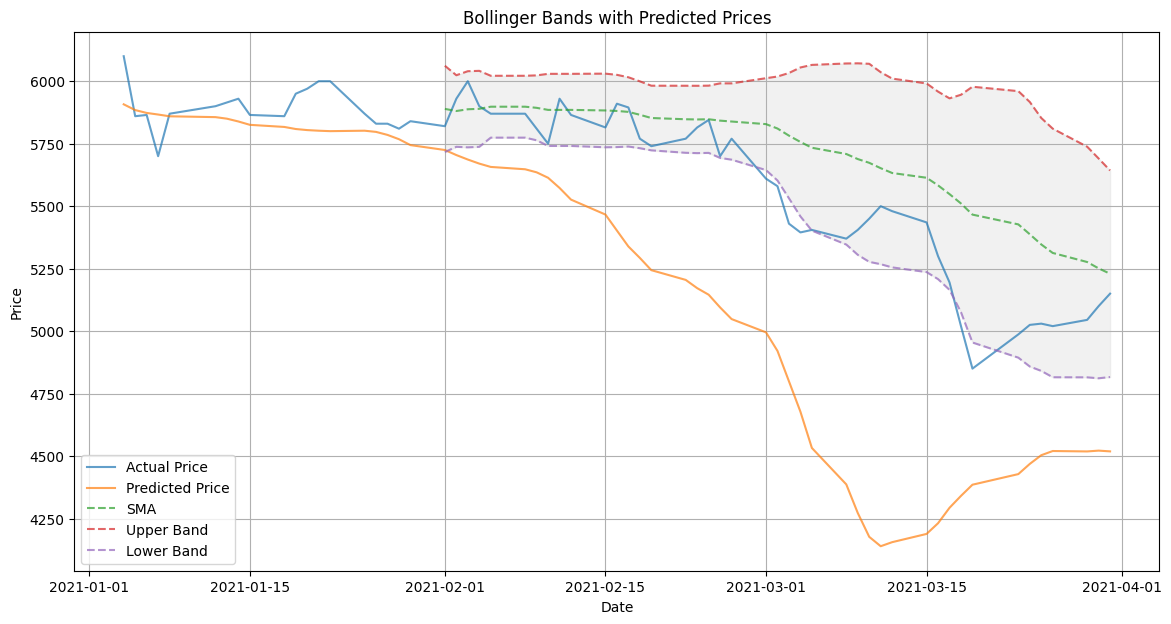

Final capital: 1000


<ipython-input-14-5da0fe9e1c87>:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if predictions[i] > df['Upper'][i] and capital > 0: # Buy signal
<ipython-input-14-5da0fe9e1c87>:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif predictions[i] < df['Lower'][i] and shares > 0: # Sell signal


In [ ]:
# Compare actual data and prediction
company_name = 'Colombia - Cementos Argos SA (C'
# Extract actual prices for Jan, Feb, Mar 2021
actual_prices_2021 = cleaned_df['2021-01-01':'2021-03-31']

# Extract predicted prices (adjust to your horizon)
predicted_prices_2021 = predictions_dict[company_name]['1-day'][:len(actual_prices_2021)]

# Ensure both dataframes have the same index
# The problem lies here, predicted_prices_2021 is 2D, flatten to 1D
predicted_prices_2021 = pd.Series(predicted_prices_2021.flatten(), index=actual_prices_2021.index)


final_capital = trading_algorithm(actual_prices_2021, predicted_prices_2021)

# Bollinger Band for Daily Prediction South Africa

<ipython-input-14-5da0fe9e1c87>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA'] = df['Price'].rolling(window=window).mean()
<ipython-input-14-5da0fe9e1c87>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['StdDev'] = df['Price'].rolling(window=window).std()
<ipython-input-14-5da0fe9e1c87>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

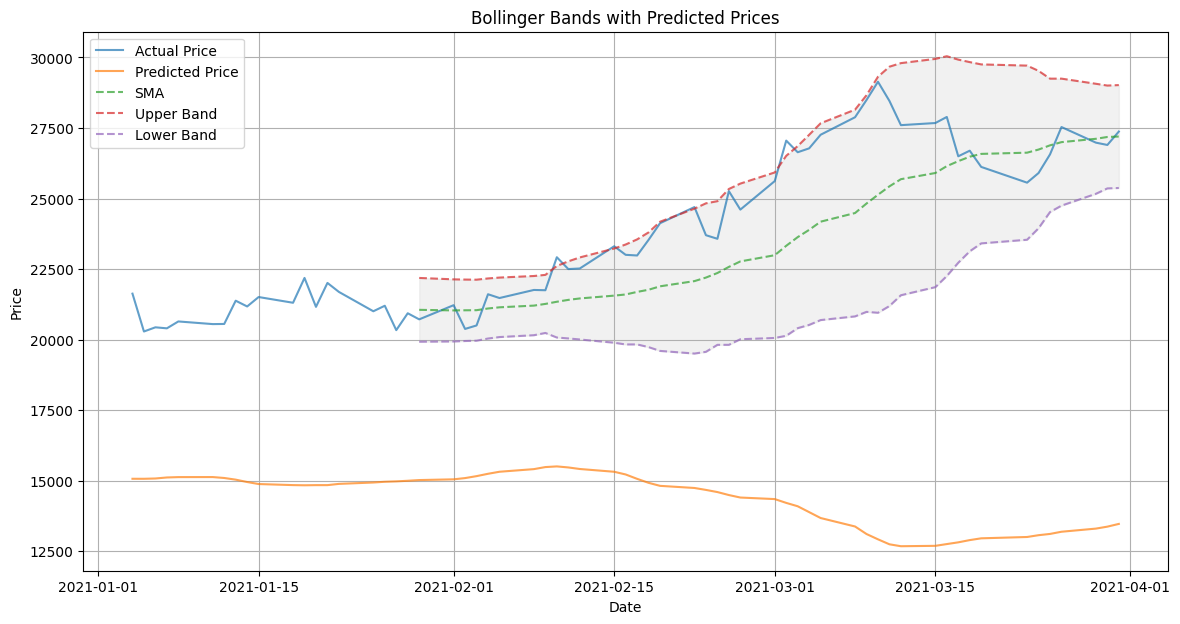

Final capital: 1000


<ipython-input-14-5da0fe9e1c87>:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if predictions[i] > df['Upper'][i] and capital > 0: # Buy signal
<ipython-input-14-5da0fe9e1c87>:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif predictions[i] < df['Lower'][i] and shares > 0: # Sell signal


In [ ]:
# Compare actual data and prediction
company_name = 'South Africa - Impala Platinum '
# Extract actual prices for Jan, Feb, Mar 2021
actual_prices_2021 = cleaned_df['2021-01-01':'2021-03-31']

# Extract predicted prices (adjust to your horizon)
predicted_prices_2021 = predictions_dict[company_name]['1-day'][:len(actual_prices_2021)]

# Ensure both dataframes have the same index
# The problem lies here, predicted_prices_2021 is 2D, flatten to 1D
predicted_prices_2021 = pd.Series(predicted_prices_2021.flatten(), index=actual_prices_2021.index)


final_capital = trading_algorithm(actual_prices_2021, predicted_prices_2021)

# Bollinger Band for Daily Prediction South Korea

<ipython-input-14-5da0fe9e1c87>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA'] = df['Price'].rolling(window=window).mean()
<ipython-input-14-5da0fe9e1c87>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['StdDev'] = df['Price'].rolling(window=window).std()
<ipython-input-14-5da0fe9e1c87>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

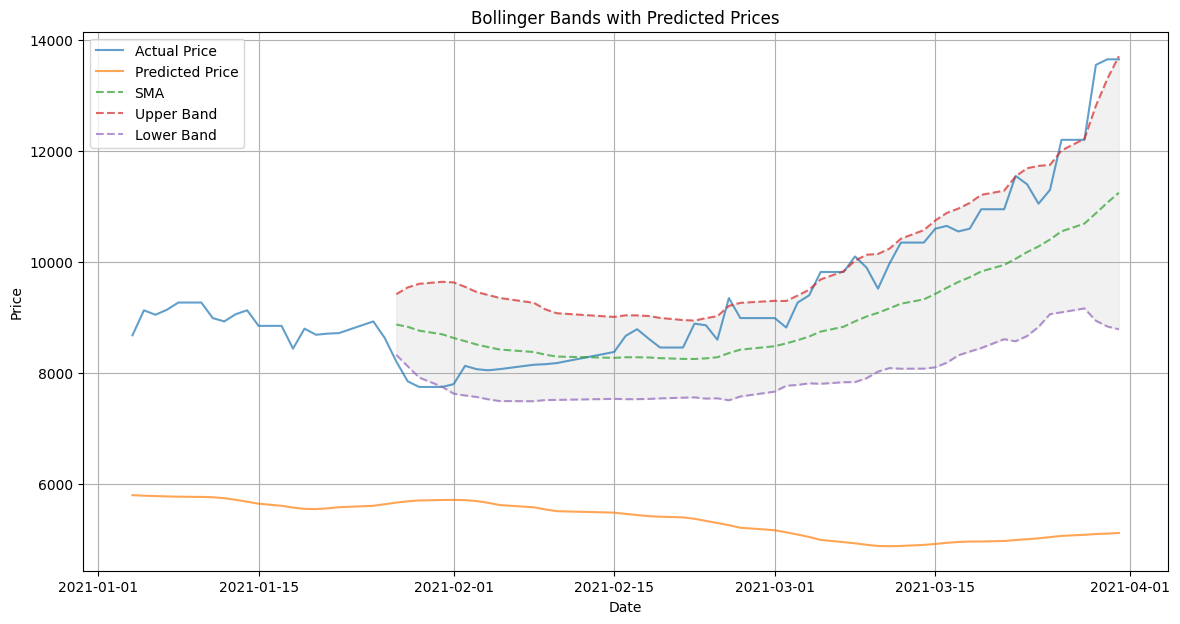

Final capital: 1000


<ipython-input-14-5da0fe9e1c87>:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if predictions[i] > df['Upper'][i] and capital > 0: # Buy signal
<ipython-input-14-5da0fe9e1c87>:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif predictions[i] < df['Lower'][i] and shares > 0: # Sell signal


In [ ]:
# Compare actual data and prediction
company_name = 'South Korea - Dongkuk Steel Mil'
# Extract actual prices for Jan, Feb, Mar 2021
actual_prices_2021 = cleaned_df['2021-01-01':'2021-03-31']

# Extract predicted prices (adjust to your horizon)
predicted_prices_2021 = predictions_dict[company_name]['1-day'][:len(actual_prices_2021)]

# Ensure both dataframes have the same index
# The problem lies here, predicted_prices_2021 is 2D, flatten to 1D
predicted_prices_2021 = pd.Series(predicted_prices_2021.flatten(), index=actual_prices_2021.index)


final_capital = trading_algorithm(actual_prices_2021, predicted_prices_2021)

# Portfolio

In [18]:
# Function to calculate Bollinger Bands
def calculate_bollinger_bands(prices, window=20, num_std=2):
    """
    Calculates Bollinger Bands for a series of prices.
    Args:
        prices: A pandas Series of stock prices.
        window: Moving average window size.
        num_std: Number of standard deviations for the bands.
    Returns:
        A DataFrame with columns for MA, Upper Band, and Lower Band.
    """
    ma = prices.rolling(window=window).mean()  # Moving average
    std = prices.rolling(window=window).std()  # Rolling standard deviation
    upper_band = ma + (num_std * std)
    lower_band = ma - (num_std * std)
    return pd.DataFrame({"MA": ma, "Upper Band": upper_band, "Lower Band": lower_band})

# Post-processing to define BUY, HOLD, SELL decisions
def classify_decisions(predicted_prices, bollinger_df):
    """
    Classify BUY, HOLD, SELL based on predicted prices and Bollinger Bands.
    Args:
        predicted_prices: Array of predicted prices.
        bollinger_df: DataFrame with Bollinger Band calculations.
    Returns:
        List of decisions (BUY, HOLD, SELL).
    """
    decisions = []
    # Ensure predicted_prices is 1-dimensional
    predicted_prices = predicted_prices.flatten()  # Added this line to flatten if it's 2D
    for i, price in enumerate(predicted_prices):
        if price < bollinger_df["Lower Band"].iloc[i]:
            decisions.append("BUY")
        elif price > bollinger_df["Upper Band"].iloc[i]:
            decisions.append("SELL")
        else:
            decisions.append("HOLD")
    return decisions

# Portfolio simulation
def simulate_portfolio(initial_capital, decisions, predicted_prices, actual_prices):
    """
    Simulates portfolio returns based on BUY, HOLD, SELL decisions.
    Args:
        initial_capital: Starting capital.
        decisions: List of BUY, HOLD, SELL decisions.
        predicted_prices: Array of predicted prices.
        actual_prices: Array of actual stock prices.
    Returns:
        Final capital and transaction log.
    """
    capital = initial_capital
    shares = 0
    transactions = []
    for i, decision in enumerate(decisions):
        if decision == "BUY" and capital >= actual_prices[i]:
            shares = capital // actual_prices[i]
            capital -= shares * actual_prices[i]
            transactions.append(f"BUY {shares} shares at {actual_prices[i]}")
        elif decision == "SELL" and shares > 0:
            capital += shares * actual_prices[i]
            transactions.append(f"SELL {shares} shares at {actual_prices[i]}")
            shares = 0
        else:
            transactions.append("HOLD")
    # Calculate final portfolio value
    final_value = capital + (shares * actual_prices[-1])
    return final_value, transactions

# Example integration with predictions
def enhanced_postprocessing(predicted_prices, actual_prices, historical_prices, initial_capital=10000):
    """
    Example integration with postprocessing logic:
    - Calculates Bollinger Bands.
    - Makes BUY, HOLD, SELL decisions.
    - Simulates portfolio returns.
    """
    # Calculate Bollinger Bands using historical prices
    bollinger_df = calculate_bollinger_bands(historical_prices)

    # Classify decisions based on Bollinger Bands
    decisions = classify_decisions(predicted_prices, bollinger_df)

    # Simulate portfolio based on decisions
    final_value, transactions = simulate_portfolio(initial_capital, decisions, predicted_prices, actual_prices)

    print("\nPortfolio Simulation Results:")
    print(f"Final Portfolio Value: ${final_value:.2f}")
    print("Transactions:")
    for transaction in transactions:
        print(transaction)
    return decisions, final_value

In [23]:
# Assuming 'Russia' is the name of the sheet
company_name = 'Russia - Sberbank Rossii PAO (S' # Adjust based on your sheet name
df = sheets_dict[company_name]  # Extract data for Russia company
cleaned_df = init_preprocess(df)  # Preprocess the data

# Define parameters
window_size = 10
prediction_horizon = 5  # Weekly prediction (5 days)

# Extract historical prices and actual prices for evaluation
historical_prices = cleaned_df['Price'][:-window_size]  # Use all but the last `window_size` for Bollinger Bands
actual_prices = cleaned_df['Price'][-window_size:]  # Use the last `window_size` for evaluation

# Predict using the LSTM model
predicted_prices = process_company(cleaned_df, window_size, prediction_horizon=prediction_horizon)

# Perform enhanced post-processing
decisions, final_portfolio_value = enhanced_postprocessing(
    predicted_prices=predicted_prices,
    actual_prices=actual_prices.values,  # Convert actual prices to numpy array
    historical_prices=historical_prices,
    initial_capital=10000  # Starting capital
)

# Print decisions and final portfolio value
print(f"\nDecisions for {company_name}: {decisions}")
print(f"Final Portfolio Value for {company_name}: ${final_portfolio_value:.2f}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 311 entries, 2020-01-03 to 2021-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     311 non-null    float64
 1   Open      311 non-null    float64
 2   High      311 non-null    float64
 3   Low       311 non-null    float64
 4   Vol.      311 non-null    float64
 5   Change %  311 non-null    float64
dtypes: float64(6)
memory usage: 17.0 KB
             Price    Open    High     Low        Vol.  Change %
Date                                                            
2021-03-25  286.66  286.50  287.03  283.85  35220000.0    0.0030
2021-03-26  291.22  288.63  292.75  288.32  56070000.0    0.0159
2021-03-29  293.30  289.72  294.09  289.26  43680000.0    0.0071
2021-03-30  293.25  294.86  295.72  291.50  38810000.0   -0.0002
2021-03-31  291.02  294.00  294.42  290.26  47000000.0   -0.0076
Epoch 1/10, Loss: 0.1615, Test Loss: 0.5753
Epoch 2/10, Loss: 0.1290,

NameError: name 'calculate_boll' is not defined

# Portfolio Version 2

In [16]:
# Function to calculate Bollinger Bands

def calculate_bollinger_bands(prices, window=20, num_std=2):
    """
    Calculates Bollinger Bands for a series of prices.
    Args:
        prices: A pandas Series of stock prices.
        window: Moving average window size.
        num_std: Number of standard deviations for the bands.
    Returns:
        A DataFrame with columns for MA, Upper Band, and Lower Band.
    """
    ma = prices.rolling(window=window).mean()  # Moving average
    std = prices.rolling(window=window).std()  # Rolling standard deviation
    upper_band = ma + (num_std * std)
    lower_band = ma - (num_std * std)
    return pd.DataFrame({"MA": ma, "Upper Band": upper_band, "Lower Band": lower_band})

# Post-processing to define BUY, HOLD, SELL decisions
def classify_decisions(predicted_prices, bollinger_df):
    """
    Classify BUY, HOLD, SELL based on predicted prices and Bollinger Bands.
    Args:
        predicted_prices: Array of predicted prices.
        bollinger_df: DataFrame with Bollinger Band calculations.
    Returns:
        List of decisions (BUY, HOLD, SELL).
    """
    decisions = []
    # Ensure predicted_prices is 1-dimensional
    # predicted_prices = predicted_prices.flatten()  # Added this line to flatten if it's 2D
    predicted_prices = predicted_prices.to_numpy() if isinstance(predicted_prices, pd.Series) else predicted_prices.flatten()

    # Get the minimum length to avoid index error
    min_len = min(len(predicted_prices), len(bollinger_df)) # Get minimum length
    for i, price in enumerate(predicted_prices[:min_len]):  # Only iterate up to the minimum length
        if price < bollinger_df["Lower Band"].iloc[i]:
            decisions.append("BUY")
        elif price > bollinger_df["Upper Band"].iloc[i]:
            decisions.append("SELL")
        else:
            decisions.append("HOLD")
    return decisions

# Portfolio simulation
def simulate_portfolio(initial_capital, decisions, predicted_prices, actual_prices):
    """
    Simulates portfolio returns based on BUY, HOLD, SELL decisions.
    Args:
        initial_capital: Starting capital.
        decisions: List of BUY, HOLD, SELL decisions.
        predicted_prices: Array of predicted prices.
        actual_prices: Array of actual stock prices.
    Returns:
        Final capital and transaction log.
    """
    capital = initial_capital
    shares = 0
    transactions = []
    # Get the minimum length to avoid index error
    min_len = min(len(decisions), len(actual_prices))
    for i, decision in enumerate(decisions[:min_len]):  # Iterate only up to min_len
        if decision == "BUY" and capital >= actual_prices[i]:
            shares = capital // actual_prices[i]
            capital -= shares * actual_prices[i]
            transactions.append(f"BUY {shares} shares at {actual_prices[i]}")
        elif decision == "SELL" and shares > 0:
            capital += shares * actual_prices[i]
            transactions.append(f"SELL {shares} shares at {actual_prices[i]}")
            shares = 0
        else:
            transactions.append("HOLD")
    # Calculate final portfolio value
    final_value = capital + (shares * actual_prices[-1])
    return final_value, transactions

# Integration with predictions
def enhanced_postprocessing(predicted_prices, actual_prices, historical_prices, initial_capital):
    """
    Integration with postprocessing logic:
    - Calculates Bollinger Bands.
    - Makes BUY, HOLD, SELL decisions.
    - Simulates portfolio returns.
    """
    # Calculate Bollinger Bands using historical prices
    bollinger_df = calculate_bollinger_bands(historical_prices)

    # Classify decisions based on Bollinger Bands
    decisions = classify_decisions(predicted_prices, bollinger_df)

    # Simulate portfolio based on decisions
    final_value, transactions = simulate_portfolio(initial_capital, decisions, predicted_prices, actual_prices)

    print("\nPortfolio Simulation Results:")
    print(f"Final Portfolio Value: ${final_value:.2f}")
    print("Transactions:")
    for transaction in transactions:
        print(transaction)
    return decisions, final_value, bollinger_df

# Plot 1

In [23]:
# Visualize the bollinger band by add a plot, make easily under stand and make trigger mark for buy, seel, hold suggestion

import matplotlib.pyplot as plt

"""def plot_bollinger_bands(prices, bollinger_df, decisions):
    Plots Bollinger Bands with buy/sell/hold signals.
    plt.figure(figsize=(12, 6))
    plt.plot(prices, label="Price", color="blue")
    plt.plot(bollinger_df["MA"], label="Moving Average", color="orange")
    plt.plot(bollinger_df["Upper Band"], label="Upper Band", color="green")
    plt.plot(bollinger_df["Lower Band"], label="Lower Band", color="red")"""

def plot_bollinger_bands(prices, bollinger_df, decisions, predicted_prices):  # Add predicted_prices parameter
    """Plots Bollinger Bands with buy/sell/hold signals and predicted prices."""
    plt.figure(figsize=(12, 6))

    # Plot actual prices
    plt.plot(prices, label="Actual Price", color="blue")  # Changed label to "Actual Price"

    # Plot predicted prices
    plt.plot(prices.index, predicted_prices, label="Predicted Price", color="purple", linestyle="--")  # Added predicted prices plot

    plt.plot(bollinger_df["MA"], label="Moving Average", color="orange")
    plt.plot(bollinger_df["Upper Band"], label="Upper Band", color="green")
    plt.plot(bollinger_df["Lower Band"], label="Lower Band", color="red")


    # Add markers for buy, sell, and hold signals
    buy_signals = [i for i, decision in enumerate(decisions) if decision == "BUY"]
    sell_signals = [i for i, decision in enumerate(decisions) if decision == "SELL"]
    hold_signals = [i for i, decision in enumerate(decisions) if decision == "HOLD"]

    plt.scatter(prices.index[buy_signals], prices.iloc[buy_signals], marker="^", color="green", label="Buy", s=100)
    plt.scatter(prices.index[sell_signals], prices.iloc[sell_signals], marker="v", color="red", label="Sell", s=100)
    plt.scatter(prices.index[hold_signals], prices.iloc[hold_signals], marker="o", color="blue", label="Hold", s=50)


    plt.title("Bollinger Bands with Buy/Sell/Hold Signals")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()


# Plot 2

# Final plot


In [30]:
# Visualize the bollinger band by add a plot, make easily under stand and make trigger mark for buy, seel, hold suggestion
def plot_bollinger_bands(prices, bollinger_df, decisions, predicted_prices):  # Add predicted_prices parameter
    """Plots Bollinger Bands with buy/sell/hold signals and predicted prices."""
    plt.figure(figsize=(14, 7))

    # Plot actual prices
    plt.plot(prices, label="Actual Price", color="blue")  # Changed label to "Actual Price"

    # Plot predicted prices, align predicted_prices to the index of prices
    # Get minimum length to avoid exceeding index bounds
    min_len = min(len(prices), predicted_prices.shape[0])
    plt.plot(prices.index[:min_len], predicted_prices[:min_len,0], label="Predicted Price", color="purple", linestyle="--")  # Added predicted prices plot

    plt.plot(bollinger_df["MA"], label="Moving Average", color="orange")
    plt.plot(bollinger_df["Upper Band"], label="Upper Band", color="green")
    plt.plot(bollinger_df["Lower Band"], label="Lower Band", color="red")

    # Add markers for buy, sell, and hold signals
    # Limit signals to the length of prices
    buy_signals = [i for i, decision in enumerate(decisions) if decision == "BUY" and i < len(prices)]
    sell_signals = [i for i, decision in enumerate(decisions) if decision == "SELL" and i < len(prices)]
    hold_signals = [i for i, decision in enumerate(decisions) if decision == "HOLD" and i < len(prices)]

    # Use a consistent index for buy/sell/hold signal plotting
    plt.scatter(prices.index[buy_signals], prices.iloc[buy_signals], marker="^", color="green", label="Buy", s=100)
    plt.scatter(prices.index[sell_signals], prices.iloc[sell_signals], marker="v", color="red", label="Sell", s=100)
    plt.scatter(prices.index[hold_signals], prices.iloc[hold_signals], marker="o", color="blue", label="Hold", s=50)


    plt.title("Bollinger Bands with Buy/Sell/Hold Signals")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 311 entries, 2020-01-03 to 2021-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     311 non-null    float64
 1   Open      311 non-null    float64
 2   High      311 non-null    float64
 3   Low       311 non-null    float64
 4   Vol.      311 non-null    float64
 5   Change %  311 non-null    float64
dtypes: float64(6)
memory usage: 17.0 KB
             Price    Open    High     Low        Vol.  Change %
Date                                                            
2021-03-25  286.66  286.50  287.03  283.85  35220000.0    0.0030
2021-03-26  291.22  288.63  292.75  288.32  56070000.0    0.0159
2021-03-29  293.30  289.72  294.09  289.26  43680000.0    0.0071
2021-03-30  293.25  294.86  295.72  291.50  38810000.0   -0.0002
2021-03-31  291.02  294.00  294.42  290.26  47000000.0   -0.0076
Epoch 1/10, Loss: 0.2359, Test Loss: 0.6465
Epoch 2/10, Loss: 0.1479,

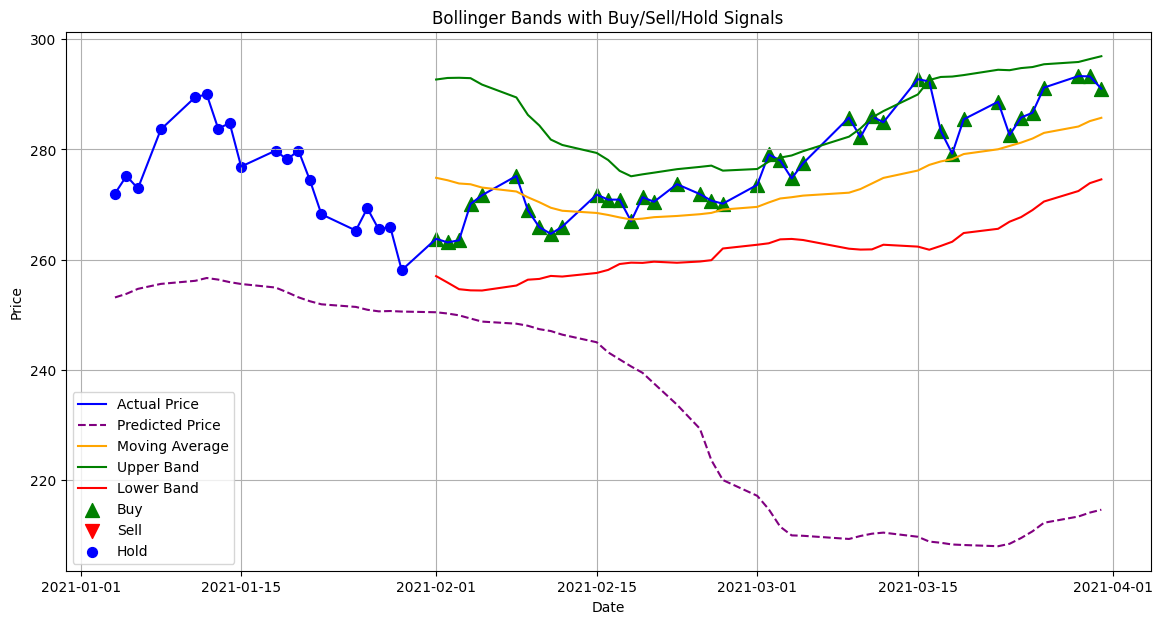


Decisions for Russia - Sberbank Rossii PAO (S: ['HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'SELL', 'SELL', 'SELL', 'SELL', '

In [36]:
# Assuming 'Russia' is the name of the sheet
company_name = 'Russia - Sberbank Rossii PAO (S'
df = sheets_dict[company_name]  # Extract data for Russia company
cleaned_df = init_preprocess(df)  # Preprocess the data

# Define parameters
window_size = 10
prediction_horizon = 1  # Daily prediction (1 days)

# Select only data for 2021
df_2021 = cleaned_df['2021-01-01':'2021-12-31']

# Predict using the LSTM model for 2021 data
predicted_prices_2021 = process_company(cleaned_df, window_size, prediction_horizon=prediction_horizon)

# Calculate Bollinger Bands for 2021 data
bollinger_df_2021 = calculate_bollinger_bands(df_2021['Price'])

# Classify decisions for 2021 data
decisions_2021 = classify_decisions(predicted_prices_2021, bollinger_df_2021)

# Extract historical prices and actual prices for evaluation
historical_prices = cleaned_df['Price'][:-window_size]  # Use all but the last `window_size` for Bollinger Bands
actual_prices = cleaned_df['Price'][-window_size:]  # Use the last `window_size` for evaluation

# Perform enhanced post-processing
decisions, final_portfolio_value, bollinger_df = enhanced_postprocessing( # Get bollinger_df as output
    predicted_prices=predicted_prices_2021,
    actual_prices=actual_prices.values,
    historical_prices=historical_prices,
    initial_capital=10000  # Starting capital
)

# Call Plot Function of the Bollinger Bands for 2021
plot_bollinger_bands(prices=df_2021['Price'], # Use 2021 prices
                     bollinger_df=bollinger_df_2021,  # Use 2021 Bollinger Bands
                     decisions=decisions_2021,  # Use 2021 decisions
                     predicted_prices=predicted_prices_2021)  # Use 2021 predicted prices

# Print decisions and final portfolio value
print(f"\nDecisions for {company_name}: {decisions}")
print(f"Final Portfolio Value for {company_name}: ${final_portfolio_value:.2f}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 311 entries, 2020-01-03 to 2021-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     311 non-null    float64
 1   Open      311 non-null    float64
 2   High      311 non-null    float64
 3   Low       311 non-null    float64
 4   Vol.      311 non-null    float64
 5   Change %  311 non-null    float64
dtypes: float64(6)
memory usage: 17.0 KB
             Price    Open    High     Low        Vol.  Change %
Date                                                            
2021-03-25  286.66  286.50  287.03  283.85  35220000.0    0.0030
2021-03-26  291.22  288.63  292.75  288.32  56070000.0    0.0159
2021-03-29  293.30  289.72  294.09  289.26  43680000.0    0.0071
2021-03-30  293.25  294.86  295.72  291.50  38810000.0   -0.0002
2021-03-31  291.02  294.00  294.42  290.26  47000000.0   -0.0076
Epoch 1/10, Loss: 0.2168, Test Loss: 0.6942
Epoch 2/10, Loss: 0.1831,

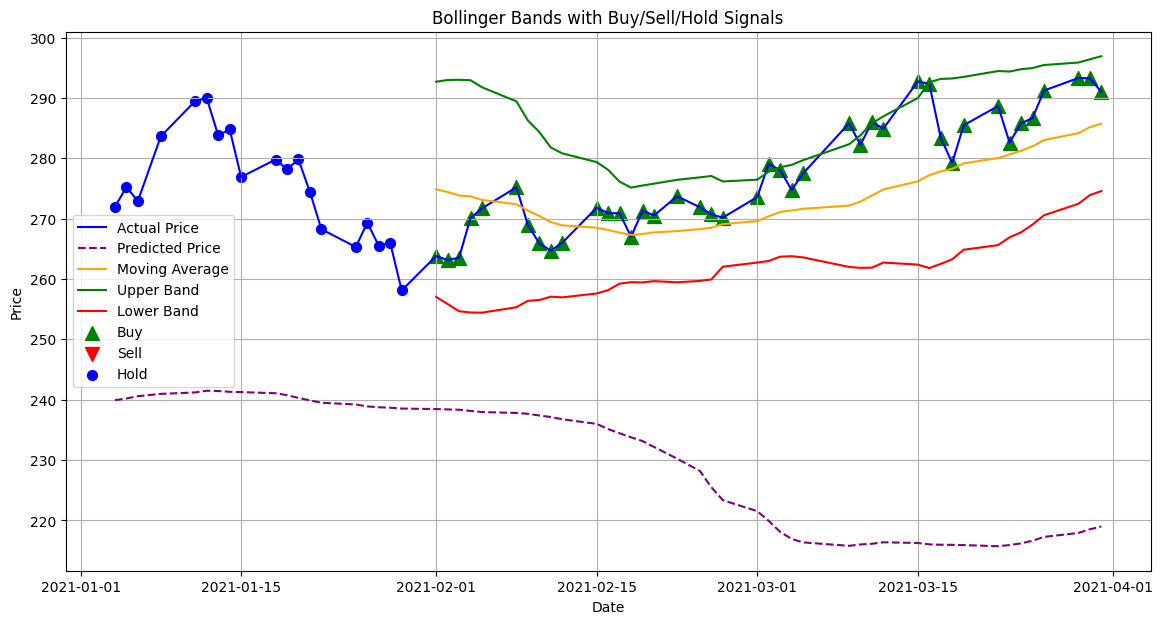


Decisions for Russia - Sberbank Rossii PAO (S: ['HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'BUY', 'BUY', 'BUY', 'BUY', 'HOLD', 'BUY', 'BUY', 'BUY', 'HOLD', 'HOLD', 'BUY', 'BUY', 'BUY', 'HOLD', 'HOLD', 'BUY', 'BUY', 'BUY', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SEL

In [37]:
# Assuming 'Russia' is the name of the sheet
company_name = 'Russia - Sberbank Rossii PAO (S'
df = sheets_dict[company_name]  # Extract data for Russia company
cleaned_df = init_preprocess(df)  # Preprocess the data

# Define parameters
window_size = 10
prediction_horizon = 5  # Weeky prediction (5 days)

# Select only data for 2021
df_2021 = cleaned_df['2021-01-01':'2021-12-31']

# Predict using the LSTM model for 2021 data
predicted_prices_2021 = process_company(cleaned_df, window_size, prediction_horizon=prediction_horizon)

# Calculate Bollinger Bands for 2021 data
bollinger_df_2021 = calculate_bollinger_bands(df_2021['Price'])

# Classify decisions for 2021 data
decisions_2021 = classify_decisions(predicted_prices_2021, bollinger_df_2021)

# Extract historical prices and actual prices for evaluation
historical_prices = cleaned_df['Price'][:-window_size]  # Use all but the last `window_size` for Bollinger Bands
actual_prices = cleaned_df['Price'][-window_size:]  # Use the last `window_size` for evaluation

# Perform enhanced post-processing
decisions, final_portfolio_value, bollinger_df = enhanced_postprocessing( # Get bollinger_df as output
    predicted_prices=predicted_prices_2021,
    actual_prices=actual_prices.values,
    historical_prices=historical_prices,
    initial_capital=10000  # Starting capital
)

# Call Plot Function of the Bollinger Bands for 2021
plot_bollinger_bands(prices=df_2021['Price'], # Use 2021 prices
                     bollinger_df=bollinger_df_2021,  # Use 2021 Bollinger Bands
                     decisions=decisions_2021,  # Use 2021 decisions
                     predicted_prices=predicted_prices_2021)  # Use 2021 predicted prices

# Print decisions and final portfolio value
print(f"\nDecisions for {company_name}: {decisions}")
print(f"Final Portfolio Value for {company_name}: ${final_portfolio_value:.2f}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 311 entries, 2020-01-03 to 2021-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     311 non-null    float64
 1   Open      311 non-null    float64
 2   High      311 non-null    float64
 3   Low       311 non-null    float64
 4   Vol.      311 non-null    float64
 5   Change %  311 non-null    float64
dtypes: float64(6)
memory usage: 17.0 KB
             Price    Open    High     Low        Vol.  Change %
Date                                                            
2021-03-25  286.66  286.50  287.03  283.85  35220000.0    0.0030
2021-03-26  291.22  288.63  292.75  288.32  56070000.0    0.0159
2021-03-29  293.30  289.72  294.09  289.26  43680000.0    0.0071
2021-03-30  293.25  294.86  295.72  291.50  38810000.0   -0.0002
2021-03-31  291.02  294.00  294.42  290.26  47000000.0   -0.0076
Epoch 1/10, Loss: 0.2740, Test Loss: 0.7281
Epoch 2/10, Loss: 0.1823,

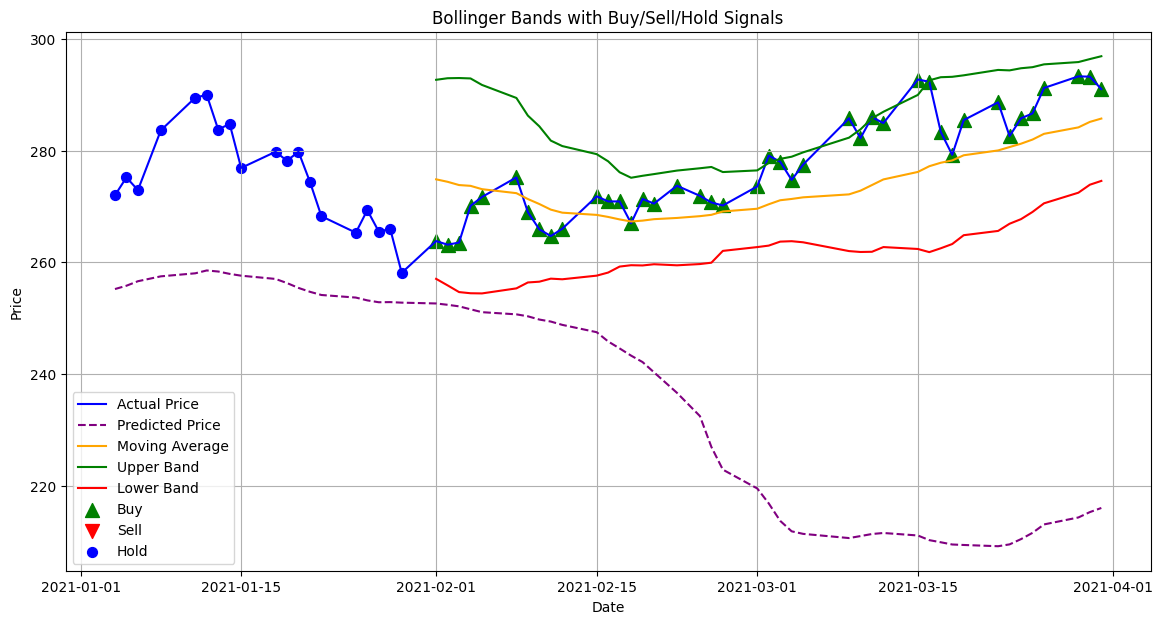


Decisions for Russia - Sberbank Rossii PAO (S: ['HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'BUY', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'HOLD', 'SELL', 'SELL', 'SELL', 'SELL', 'SELL'

In [38]:
# Assuming 'Russia' is the name of the sheet
company_name = 'Russia - Sberbank Rossii PAO (S'
df = sheets_dict[company_name]  # Extract data for Russia company
cleaned_df = init_preprocess(df)  # Preprocess the data

# Define parameters
window_size = 10
prediction_horizon = 1  # Monthly prediction (20 days)

# Select only data for 2021
df_2021 = cleaned_df['2021-01-01':'2021-12-31']

# Predict using the LSTM model for 2021 data
predicted_prices_2021 = process_company(cleaned_df, window_size, prediction_horizon=prediction_horizon)

# Calculate Bollinger Bands for 2021 data
bollinger_df_2021 = calculate_bollinger_bands(df_2021['Price'])

# Classify decisions for 2021 data
decisions_2021 = classify_decisions(predicted_prices_2021, bollinger_df_2021)

# Extract historical prices and actual prices for evaluation
historical_prices = cleaned_df['Price'][:-window_size]  # Use all but the last `window_size` for Bollinger Bands
actual_prices = cleaned_df['Price'][-window_size:]  # Use the last `window_size` for evaluation

# Perform enhanced post-processing
decisions, final_portfolio_value, bollinger_df = enhanced_postprocessing( # Get bollinger_df as output
    predicted_prices=predicted_prices_2021,
    actual_prices=actual_prices.values,
    historical_prices=historical_prices,
    initial_capital=10000  # Starting capital
)

# Call Plot Function of the Bollinger Bands for 2021
plot_bollinger_bands(prices=df_2021['Price'], # Use 2021 prices
                     bollinger_df=bollinger_df_2021,  # Use 2021 Bollinger Bands
                     decisions=decisions_2021,  # Use 2021 decisions
                     predicted_prices=predicted_prices_2021)  # Use 2021 predicted prices

# Print decisions and final portfolio value
print(f"\nDecisions for {company_name}: {decisions}")
print(f"Final Portfolio Value for {company_name}: ${final_portfolio_value:.2f}")

# Original Plot


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 311 entries, 2020-01-03 to 2021-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     311 non-null    float64
 1   Open      311 non-null    float64
 2   High      311 non-null    float64
 3   Low       311 non-null    float64
 4   Vol.      311 non-null    float64
 5   Change %  311 non-null    float64
dtypes: float64(6)
memory usage: 17.0 KB
             Price    Open    High     Low        Vol.  Change %
Date                                                            
2021-03-25  286.66  286.50  287.03  283.85  35220000.0    0.0030
2021-03-26  291.22  288.63  292.75  288.32  56070000.0    0.0159
2021-03-29  293.30  289.72  294.09  289.26  43680000.0    0.0071
2021-03-30  293.25  294.86  295.72  291.50  38810000.0   -0.0002
2021-03-31  291.02  294.00  294.42  290.26  47000000.0   -0.0076
Epoch 1/10, Loss: 0.2037, Test Loss: 0.6996
Epoch 2/10, Loss: 0.1794,

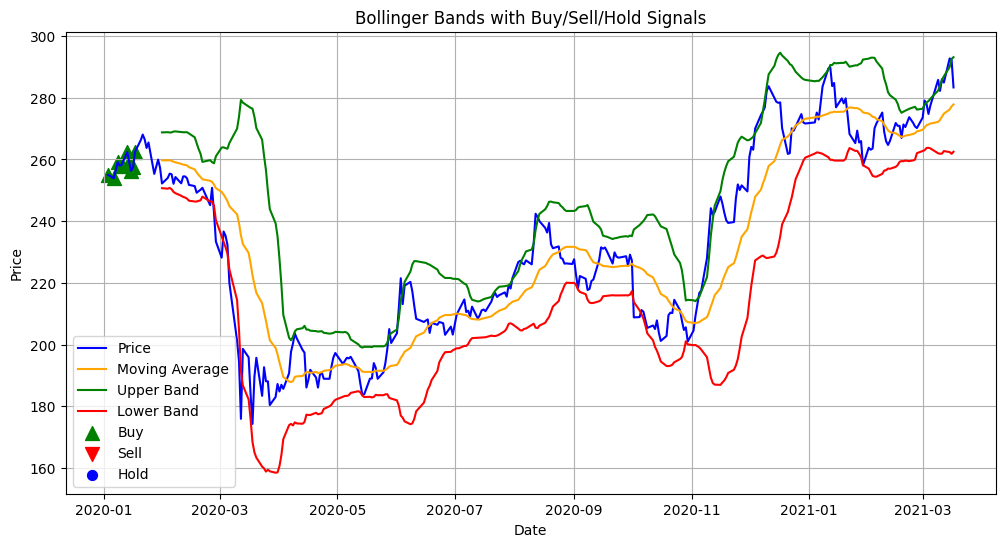

In [20]:
# Assuming 'Russia' is the name of the sheet
company_name = 'Russia - Sberbank Rossii PAO (S' # Adjust based on your sheet name
df = sheets_dict[company_name]  # Extract data for Russia company
cleaned_df = init_preprocess(df)  # Preprocess the data

# Define parameters
window_size = 10
prediction_horizon = 22  # Monthly prediction (22 days)

# Extract historical prices and actual prices for evaluation
historical_prices = cleaned_df['Price'][:-window_size]  # Use all but the last `window_size` for Bollinger Bands
actual_prices = cleaned_df['Price'][-window_size:]  # Use the last `window_size` for evaluation

# Predict using the LSTM model
predicted_prices = process_company(cleaned_df, window_size, prediction_horizon=prediction_horizon)

# Perform enhanced post-processing
decisions, final_portfolio_value, bollinger_df = enhanced_postprocessing( # Get bollinger_df as output
    predicted_prices=predicted_prices,
    actual_prices=actual_prices.values,  # Convert actual prices to numpy array
    historical_prices=historical_prices,
    initial_capital=10000  # Starting capital
)

# Print decisions and final portfolio value
print(f"\nDecisions for {company_name}: {decisions}")
print(f"Final Portfolio Value for {company_name}: ${final_portfolio_value:.2f}")

# Call plot_bollinger_bands with historical_prices and limit signals to actual_prices range
plot_bollinger_bands(historical_prices, bollinger_df, decisions[-len(actual_prices):])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 311 entries, 2020-01-03 to 2021-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     311 non-null    float64
 1   Open      311 non-null    float64
 2   High      311 non-null    float64
 3   Low       311 non-null    float64
 4   Vol.      311 non-null    float64
 5   Change %  311 non-null    float64
dtypes: float64(6)
memory usage: 17.0 KB
             Price    Open    High     Low        Vol.  Change %
Date                                                            
2021-03-25  286.66  286.50  287.03  283.85  35220000.0    0.0030
2021-03-26  291.22  288.63  292.75  288.32  56070000.0    0.0159
2021-03-29  293.30  289.72  294.09  289.26  43680000.0    0.0071
2021-03-30  293.25  294.86  295.72  291.50  38810000.0   -0.0002
2021-03-31  291.02  294.00  294.42  290.26  47000000.0   -0.0076
Epoch 1/10, Loss: 0.2198, Test Loss: 0.6921
Epoch 2/10, Loss: 0.1756,

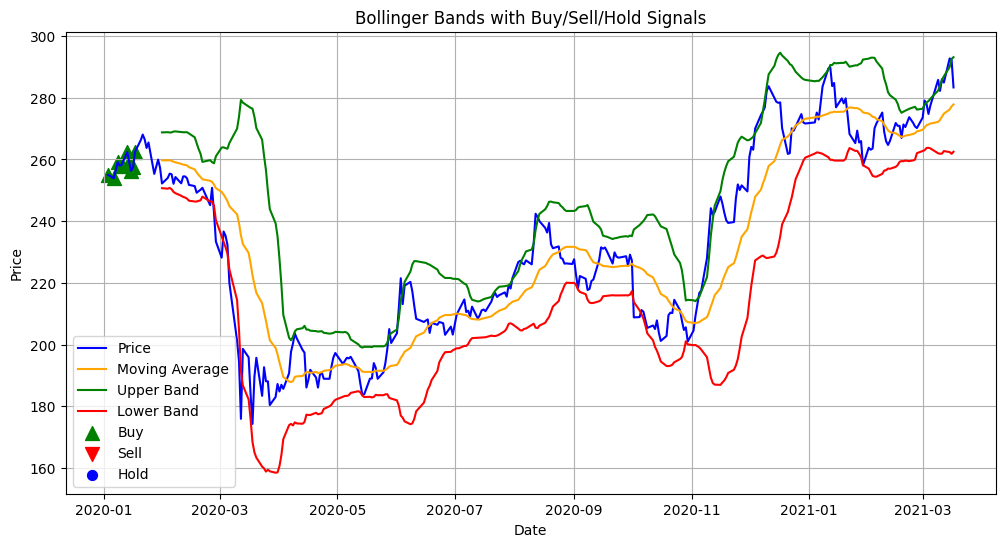

In [21]:
# Assuming 'Russia' is the name of the sheet
company_name = 'Russia - Sberbank Rossii PAO (S' # Adjust based on your sheet name
df = sheets_dict[company_name]  # Extract data for Russia company
cleaned_df = init_preprocess(df)  # Preprocess the data

# Define parameters
window_size = 10
prediction_horizon = 5  # Weekly prediction (5 days)

# Extract historical prices and actual prices for evaluation
historical_prices = cleaned_df['Price'][:-window_size]  # Use all but the last `window_size` for Bollinger Bands
actual_prices = cleaned_df['Price'][-window_size:]  # Use the last `window_size` for evaluation

# Predict using the LSTM model
predicted_prices = process_company(cleaned_df, window_size, prediction_horizon=prediction_horizon)

# Perform enhanced post-processing
decisions, final_portfolio_value, bollinger_df = enhanced_postprocessing( # Get bollinger_df as output
    predicted_prices=predicted_prices,
    actual_prices=actual_prices.values,  # Convert actual prices to numpy array
    historical_prices=historical_prices,
    initial_capital=10000  # Starting capital
)

# Print decisions and final portfolio value
print(f"\nDecisions for {company_name}: {decisions}")
print(f"Final Portfolio Value for {company_name}: ${final_portfolio_value:.2f}")
# Example usage (assuming you have 'prices', 'bollinger_df', and 'decisions' defined)
# Replace with your actual data
# Call plot_bollinger_bands with historical_prices and limit signals to actual_prices range
plot_bollinger_bands(historical_prices, bollinger_df, decisions[-len(actual_prices):])